## 🌱 Project 1: Image Classification (Plant Seedling Classification)

**Problem Statement**: Build an image classifier which will classify the images of plant seedlings.

**Target**: Lets build a basic setup model where the data can be passed and make the model learn, with a heavier parameters itself. Later we can degrade network parameter or go for higher network parameters if in needed. We can consider this as a basic version1 notebook. The later version/modified network or other parameters will be made in next version notebooks.

**Data**: Here the data is described and visualized few of images. 

**Feedback**: Any change can be made, if any new ideas or new way of dealing. Comment it, I will learn.

**Stack**: Python, PyTorch.

**The steps include,** 

    A. Importing Libraries.

    B. DataLoading & augmenting (If needed) & transformations.

    C. Visualizing.

    D. Model Building.

    E. Making the model learn.

    F. Saving the model.

    G. Relying for performance on test-data

    H. Analyzing the results.


# A. Import Libraries & Read data

In [1]:
# !pip install cudf
!pip install torchsummary

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import random
from copy import deepcopy

import albumentations as A 

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

import torch.backends.cudnn as cudnn 
import colorama
import torchvision 
from torchvision.transforms import transforms
from torch.utils.data import Dataset,DataLoader

renaming = {"Scentless Mayweed":"scentless_mayweed","Common wheat":"common_wheat","Black-grass":"black_grass",
           "Sugar beet":"sugar_beet","Loose Silky-bent":"loose_silky_bent","Common Chickweed":"common_chickweed",
           "Fat Hen":"fat_hen","Small-flowered Cranesbill":"small_flowered_cranesbill","Shepherds Purse":"shepherds_Purse"}

classes = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    class_name = dirname.split('/')
    
    if len(class_name)>5:
        label = class_name[-1]
        if label in renaming:
            class_name[-1] = renaming[label]
        else:
            lower_cased = class_name[-1].lower()
            renaming[class_name[-1]] = lower_cased
            class_name[-1] = lower_cased
        source = dirname 
        dest = "/".join(class_name)
        classes.append(class_name[-1])

print(f"The classes of plant-seedlings data is :\n{classes}")
print("\n")
print(f"The total number of classes are:{len(classes)}")

The classes of plant-seedlings data is :
['scentless_mayweed', 'common_wheat', 'charlock', 'black_grass', 'sugar_beet', 'loose_silky_bent', 'maize', 'cleavers', 'common_chickweed', 'fat_hen', 'small_flowered_cranesbill', 'shepherds_Purse']


The total number of classes are:12


In [3]:
path = "/kaggle/input/plant-seedlings-classification/train/"

In [4]:
class_idx = {}
idx = 0
for cls in classes:
    class_idx[cls] = idx
    idx += 1 
print(class_idx)

{'scentless_mayweed': 0, 'common_wheat': 1, 'charlock': 2, 'black_grass': 3, 'sugar_beet': 4, 'loose_silky_bent': 5, 'maize': 6, 'cleavers': 7, 'common_chickweed': 8, 'fat_hen': 9, 'small_flowered_cranesbill': 10, 'shepherds_Purse': 11}


### **Observations:**

1. As from data, we can identify there are spaces and unconvential method of names which are not allowed in python. To make the data suitable to our tool, we can modify it to our convention.

2. As from the result, we can identify there are 12 classes & data is divided into train & test data. Let us check the data of train & test and its respective statistics.

# B. Getting Data

In [5]:
from glob import glob
train_path = glob("/kaggle/input/plant-seedlings-classification/train/*/*.png")
test_path = glob("/kaggle/input/plant-seedlings-classification/test/*.png")

In [6]:
print(f"Total of {len(train_path)} images are in train dataset")
print(f"Total of {len(test_path)} images are in test dataset")

Total of 4750 images are in train dataset
Total of 794 images are in test dataset


In [7]:
train_class_path = "/kaggle/input/plant-seedlings-classification/train/"
i = 0
data_counter = {}
for label in os.listdir(train_class_path):
    data_counter[classes[i]] = len(os.listdir(train_class_path+label+"/"))
    i += 1
    
# Representing Data.
df = pd.DataFrame(data_counter.values(),index=[classes[i] for i in range(12)],columns=['Count of Images'])
df.sort_values('Count of Images',axis=0)

,Count of Images
common_wheat,221
maize,221
shepherds_Purse,231
black_grass,263
cleavers,287
sugar_beet,385
charlock,390
fat_hen,475
small_flowered_cranesbill,496
scentless_mayweed,516


**Observations:** 

1. We can observe there are 4750 images in train_dataset & 794 in test data, summing them up gives 5544 Images dataset.

2. On an average each of class has more than 200 & less than 700 Images. 

3. The data seems to imbalanced, where few of classes has lower count and others have double the count of lower count classes. Lets deal with it in process.

In [8]:
import cv2 
lst = []
labels = np.array([])
images = np.array([])
for img in glob("/kaggle/input/plant-seedlings-classification/train/*/*.png"):
    image = cv2.imread(img,1)
    image = cv2.resize(image,(224,224))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image.transpose((2,0,1))
    label = img.split("/")[-2]
    label = renaming[label]
    label = class_idx[label]
    label = label
  
    lst.append((image,label))
    
print(len(lst))

4750


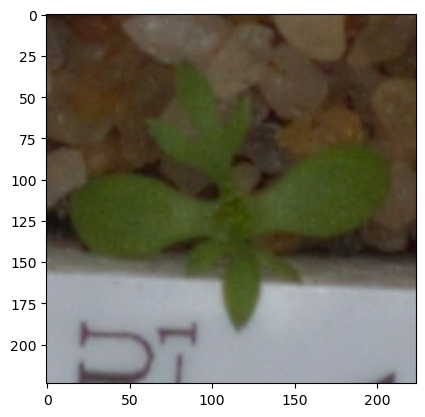

In [9]:
plt.imshow(lst[0][0].transpose(1,2,0))

**Let us visualize few samples by taking some random images**

In [10]:
lst2 = deepcopy(lst)
random.shuffle(lst2)
samples = random.sample(lst2,12)

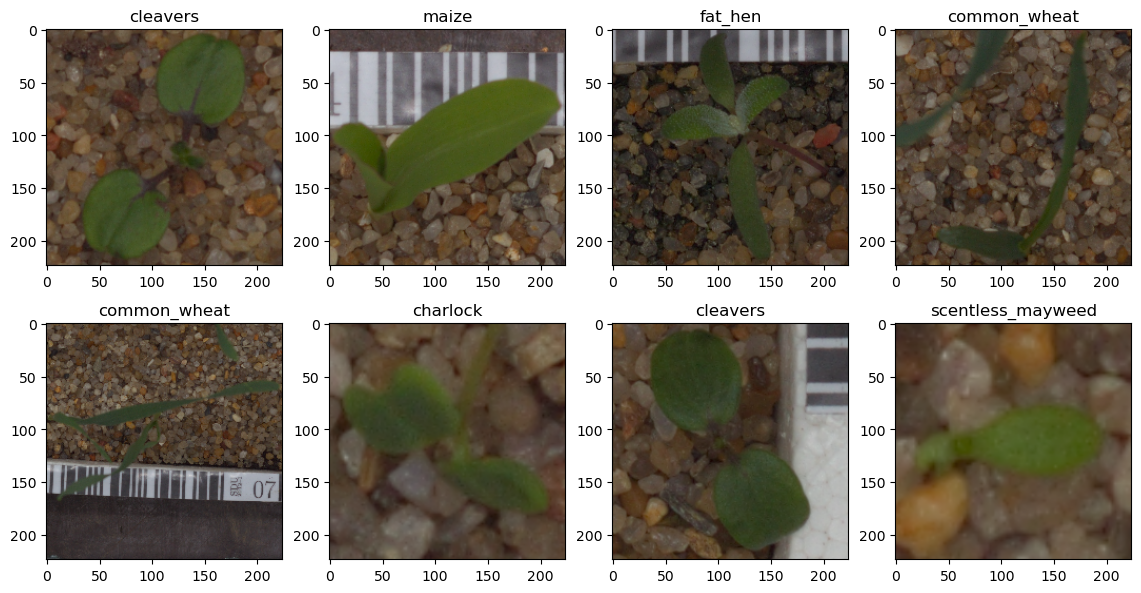

In [11]:
figure = plt.figure(figsize=(14,7))
for i in range(8):
    ax = figure.add_subplot(2,4,i+1)
    plt.imshow(samples[i][0].transpose(1,2,0))
    plt.title(classes[samples[i][1]])

**DataLoading & transforming**

In [12]:
## Custom Dataset
from glob import glob
class Seeds(Dataset):
    def __init__(self,data,transform=None):
        self.data = data 
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        image,label = self.data[idx]
        label = np.asarray(label)
        target = torch.from_numpy(label.astype('float'))
        image = torch.tensor(image).float()
        if self.transform is not None:
            image = self.transform(image)
        return (image,label)

In [13]:

# Define the dataset directory and image transforms
transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor()])

# Load the dataset
dataset = Seeds(lst, transform=transform)

# Calculate the mean and standard deviation
loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))
data = next(iter(loader))
print(data[0].shape)
mean = data[0].mean(dim=[0,2,3])
std = data[0].std(dim=[0,2,3])

print("Mean: ", mean)
print("Std Dev: ", std)

torch.Size([4750, 3, 224, 224])
Mean:  tensor([0.6756, 0.7151, 0.7941])
Std Dev:  tensor([0.1050, 0.1106, 0.1343])


In [14]:
transformss = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor(),transforms.Normalize((0.7941, 0.7151, 0.6756), (0.1343, 0.1106, 0.1050))])

In [15]:
seeds_data = Seeds(lst,transform=transformss)
seeds_data

In [16]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    cuda_kwargs = {'num_workers': 2,
                    'pin_memory': True}

In [17]:
## As we can view, the test data dont have any specific labelling directory, so we must use this for test 

In [18]:
train_count = int(len(seeds_data)*0.85)
val_count = len(lst)-train_count 
print(train_count,val_count)
train_set, val_set = torch.utils.data.random_split(seeds_data, [train_count,val_count])
print(len(train_set),len(val_set))

4037 713
4037 713


In [19]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True,**cuda_kwargs)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False,**cuda_kwargs)

In [20]:
print(len(train_loader),len(val_loader))

64 12


**Observations:**

1. Data Preparation is done, lets move to building a network

**Model Building:**

1. Need to get the receptive field more than or equal to 244.
2. 

# D. Model Building

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # Inp: 224 | out: (224+2-3)/1 + 1 = 224
            # RFin: 1, Jin: 1, S = 1, Jout = 1 
            # Rfout = Rfin + (K-1)*Jin = 3 
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # Inp: 224 | out: (224+2-3)/1 + 1 = 224
            # RFin: 3, Jin:1, S = 1, Jout = 1 
            # RFout : 3 + (3-1)*1 = 5 
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
            # Inp: 224 | out: (224+2-3)+ 1 = 224
            # RfIn: 5, Jin: 1, S = 1, Jout = 1 
            # Rfout: 5 + (3-1)*1 = 5 + 2 = 7 
            
        self.transistion1 = nn.MaxPool2d(2,2)
        # Inp: 224 | out = 224/2 = 112 
        # RFIn: 7, Jin:1, S/Pooling = 2, Jout = 2 
        # RfOut: 7 + (2-1)*1 = 8
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # Inp: 112, out: (112-3) + 1 = 110
            # Rf: 8, Jin: 2, s = 1, jout = 2 
            # Rfout: 8 + (5-1)*2 = 8 + 8 = 16 
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=5,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # inp: 112, out: (112 + 2 - 5) + 1 = 110 
            # RFIn: 16, Jin: 2, S = 1, Jout = 2 
            # RFout: 16 + (5-1)*2 = 12 + 8 = 20 
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=5,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # inp: 110, out: (110+2-5)/2 + 1 = 107/2 + 1 = 54
            # RFin: 20, Jin: 2, S = 2, Jout = 4 
            # Rfout: 20 + (5-1)*2 = 20 + 8 = 28 
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=7,stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
            # Inp: 54, out: (54-7) + 1 = 48 
            # RfIn: 28 , Jin = 4, s = 1, jout = 4 
            # rfout: 28 + (7-1)*4 = 28 + 24 = 52
            
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # inp: 48, output: (48-3) + 1 = 46 
            # RfIn: 52 , Jin = 4, S = 1 , Jout = 4 
            # Rfout: 52 + (3-1)*4 = 52 + 8 = 60 
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=7,stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # Inp: 46, out: (46-7) + 1 = 40 
            # Rfin: 60, Jin = 4, S = 1, Jout = 4 
            # Rfout: 60 + (7-1)*4 = 60 + 24 = 84 
            nn.Conv2d(in_channels=512,out_channels=256,kernel_size=1,stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
            # Inp: 40, out: (40-1) + 1 = 40 
            # Rfin: 84, Jin = 4, S=1, Jout = 4 
            # Rfout: 84 + (1-1)*4 = 84 
        
        self.transistion2 = nn.MaxPool2d(2,2)
        # Inp: 40, output: 20 
        # Rfin: 84, Jin: 4, S = 2, Jout = 8 
        # Rfout: 84 + (2-1)*4 = 88
        
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Inp: 20, output: (20+2-3) + 1 = 20
            # Rf: 88, Jin = 8, S = 1, Jout = 8 
            # Rfout = 88 + (3-1)*8 = 88 + 16 = 104 
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=7,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Inp: 20, Output: (20+2-7)+ 1 = 16 
            # Rf: 104, Jin = 8, S = 1, Jout = 8
            # Rfout = 104 + (7-1)*8 = 104 + 48 = 152 
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=7,stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # Inp: 16, output: 16-7 + 1 = 10 
            # RF: 152, Jin = 8, S = 1, Jout = 8 
            # Rfout = 152 + (7-1)*8 = 152 + 48 = 200 
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=7,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
            # Inp: 10, output : (10+2-7)/1 + 1 = 6
            # RF: 200, Jin = 8, S = 1, Jout = 8
            # Rfout = 200 + (7-1)*8  = 200 + 48 = 248 
        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            # Inp: 6, output: (6+2-3) + 1 = 6
            # Rf: 248, Jin = 8, S = 1, Jout = 8
            # RFout: 248 + (3-1)*8 = 248 + 16 = 264 
            nn.Conv2d(in_channels=32,out_channels=12,kernel_size=1,stride=1))
            # Inp: 6, out: 4 
            # RF: 264, Jin = 8, S= 1, Jout = 8 
            # RFout: 264 + (1-1)*8 = 264 
        
        self.gap = nn.AvgPool2d(4)
        self.dropout = nn.Dropout2d(0.1)
        
        
    def forward(self,x):
        x = self.block1(x)
        x = self.transistion1(x) 
        x = self.block2(x)
        x = self.dropout(x)
        x = self.block3(x)
        x = self.transistion2(x)
        x = self.block4(x)
        x = self.dropout(x)
        x = self.block5(x) 
        x = self.gap(x)
       
        x = x.view(-1,12)
        return F.log_softmax(x,dim=1)
        

**Observations**:

1. Has a receptive field of 264. 
2. Has 5 blocks with total of 16 convolution layers with 2 transistion blocks.
3. It seems like a heavy-weighted model as it will have large number of parameters.

**Summary of Model**

In [22]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           4,640
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
            Conv2d-7         [-1, 32, 224, 224]           9,248
       BatchNorm2d-8         [-1, 32, 224, 224]              64
              ReLU-9         [-1, 32, 224, 224]               0
        MaxPool2d-10         [-1, 32, 112, 112]               0
           Conv2d-11         [-1, 64, 108, 108]          51,264
      BatchNorm2d-12         [-1, 64, 108, 108]             128
             ReLU-13         [-1, 64, 108, 108]               0
           Conv2d-14        [-1, 128, 1

# E. Making the model learn and fail and learn again**

In [23]:

from tqdm import tqdm 

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
#         data = torch.tensor(data).float()
        data.float().clone().detach().requires_grad_(True)
        data, target = data.to(device), target.to(device)
        

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = criterion(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} train-Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = torch.tensor(data).float()
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = test_loss/len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, val-Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [24]:
model =  Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 24
device="cuda"
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, val_loader)

EPOCH: 0


Loss=1.15512216091156 Batch_id=63 train-Accuracy=38.69: 100%|██████████| 64/64 [01:55<00:00,  1.80s/it]  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Test set: Average loss: 0.0710, val-Accuracy: 184/713 (25.81%)

EPOCH: 1


Loss=0.8338310122489929 Batch_id=63 train-Accuracy=59.72: 100%|██████████| 64/64 [02:00<00:00,  1.88s/it]



Test set: Average loss: 0.0203, val-Accuracy: 414/713 (58.06%)

EPOCH: 2


Loss=2.127082586288452 Batch_id=63 train-Accuracy=67.57: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0376, val-Accuracy: 209/713 (29.31%)

EPOCH: 3


Loss=1.7317920923233032 Batch_id=63 train-Accuracy=69.48: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0125, val-Accuracy: 528/713 (74.05%)

EPOCH: 4


Loss=1.5531715154647827 Batch_id=63 train-Accuracy=76.34: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0211, val-Accuracy: 423/713 (59.33%)

EPOCH: 5


Loss=0.7886627912521362 Batch_id=63 train-Accuracy=78.25: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0108, val-Accuracy: 544/713 (76.30%)

EPOCH: 6


Loss=2.4272704124450684 Batch_id=63 train-Accuracy=81.15: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0122, val-Accuracy: 528/713 (74.05%)

EPOCH: 7


Loss=0.2589014172554016 Batch_id=63 train-Accuracy=80.26: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0174, val-Accuracy: 501/713 (70.27%)

EPOCH: 8


Loss=0.2586958110332489 Batch_id=63 train-Accuracy=83.97: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0083, val-Accuracy: 600/713 (84.15%)

EPOCH: 9


Loss=0.8658794164657593 Batch_id=63 train-Accuracy=85.51: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0092, val-Accuracy: 571/713 (80.08%)

EPOCH: 10


Loss=0.7800692915916443 Batch_id=63 train-Accuracy=86.70: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0075, val-Accuracy: 599/713 (84.01%)

EPOCH: 11


Loss=0.1648547202348709 Batch_id=63 train-Accuracy=87.22: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0066, val-Accuracy: 619/713 (86.82%)

EPOCH: 12


Loss=0.9347457885742188 Batch_id=63 train-Accuracy=88.93: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0066, val-Accuracy: 618/713 (86.68%)

EPOCH: 13


Loss=1.8228018283843994 Batch_id=63 train-Accuracy=88.43: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0067, val-Accuracy: 609/713 (85.41%)

EPOCH: 14


Loss=3.592336654663086 Batch_id=63 train-Accuracy=87.57: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it]  



Test set: Average loss: 0.0325, val-Accuracy: 408/713 (57.22%)

EPOCH: 15


Loss=3.383270740509033 Batch_id=63 train-Accuracy=83.50: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it]  



Test set: Average loss: 0.0120, val-Accuracy: 532/713 (74.61%)

EPOCH: 16


Loss=0.2650131583213806 Batch_id=63 train-Accuracy=83.40: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0061, val-Accuracy: 623/713 (87.38%)

EPOCH: 17


Loss=2.781188488006592 Batch_id=63 train-Accuracy=89.22: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it]  



Test set: Average loss: 0.0072, val-Accuracy: 594/713 (83.31%)

EPOCH: 18


Loss=1.931807518005371 Batch_id=63 train-Accuracy=88.28: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it]  



Test set: Average loss: 0.0078, val-Accuracy: 593/713 (83.17%)

EPOCH: 19


Loss=3.307344436645508 Batch_id=63 train-Accuracy=88.68: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it]  



Test set: Average loss: 0.0066, val-Accuracy: 611/713 (85.69%)

EPOCH: 20


Loss=0.6877633333206177 Batch_id=63 train-Accuracy=86.10: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0067, val-Accuracy: 607/713 (85.13%)

EPOCH: 21


Loss=0.43599510192871094 Batch_id=63 train-Accuracy=90.34: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it]



Test set: Average loss: 0.0071, val-Accuracy: 602/713 (84.43%)

EPOCH: 22


Loss=3.7531094551086426 Batch_id=63 train-Accuracy=91.88: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0207, val-Accuracy: 460/713 (64.52%)

EPOCH: 23


Loss=1.2068138122558594 Batch_id=63 train-Accuracy=84.91: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it] 



Test set: Average loss: 0.0063, val-Accuracy: 616/713 (86.40%)



**Observations:**

1. Validation accuracy seems to be ok, but it is fluctuating with valid predictions in btwn. as it can be seen there is a requirement of data for 80% classes. Augmentations,Dropouts, BN , etc or might have to reduce the network or increase the data., has to be added to make it improve with validation dataset predictions.

Text(0.5, 1.0, 'Test Accuracy')

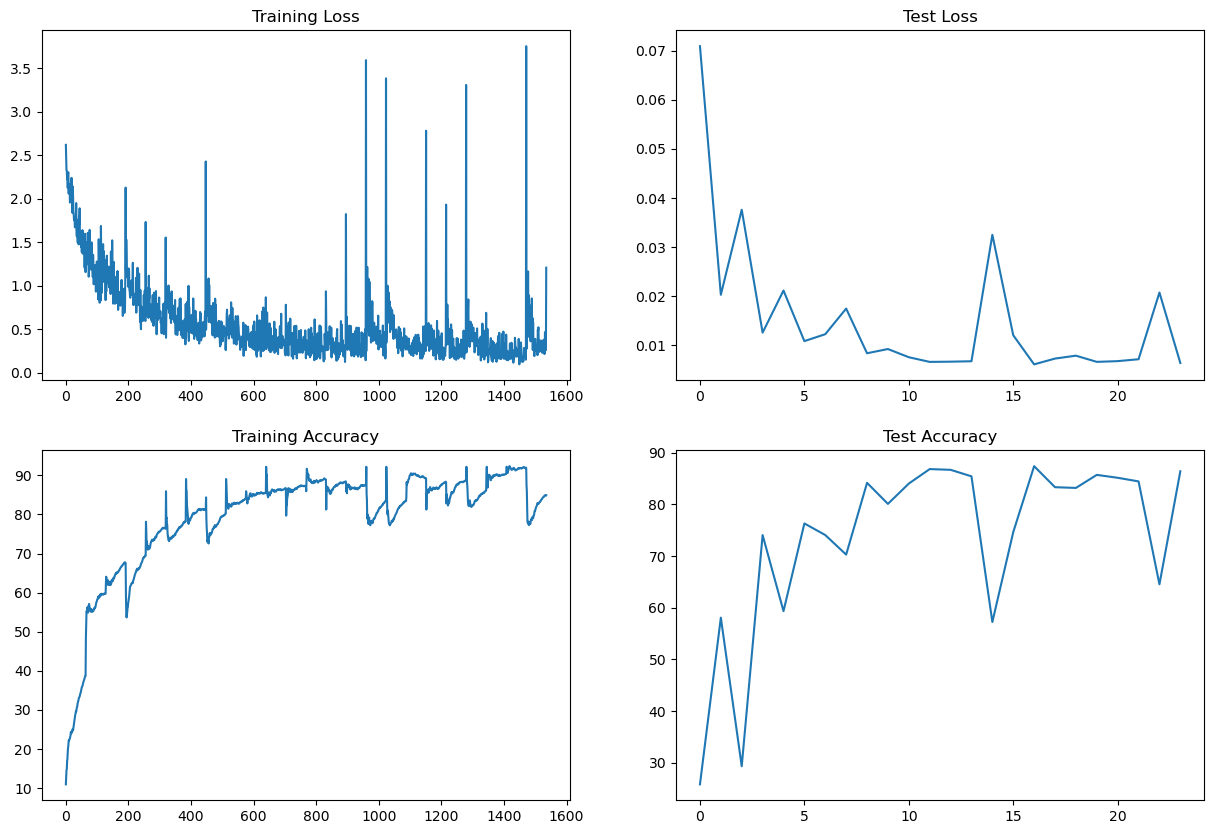

In [25]:
# Lets plot the things.
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# F. Saving the Model

In [26]:
checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [27]:
!zip -r seeds.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/checkpoint.pth (deflated 8%)
  adding: kaggle/working/__notebook_source__.ipynb (deflated 44%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)


# G. Relying on test-data for performance

In [28]:
inference_model = torch.load("/kaggle/working/checkpoint.pth")

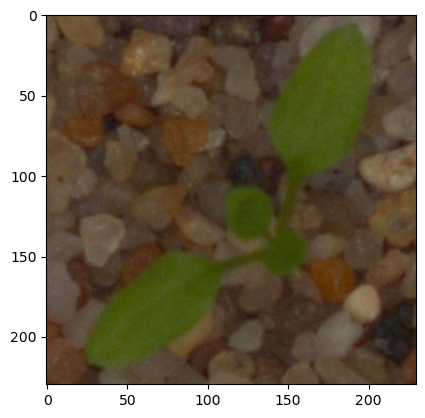

In [29]:

# Create the preprocessing transformation here
transform = transforms.ToTensor()

img = Image.open(test_path[666])
plt.imshow(img)

In [30]:
# Transform
input = transform(img)
# Set model to eval
model.eval()
input = input.unsqueeze(0).to("cuda")
print(input.shape)
# Get prediction
# output = model(input.to("cuda").float())
prediction = F.softmax(model(input), dim = 1)
prediction = prediction.argmax()
classes[prediction]

torch.Size([1, 3, 230, 230])


'loose_silky_bent'

In [31]:
print("Done!"+"Lets try to improvise the results and model in next version1 with other setup and features")

Done!Lets try to improvise the results and model in next version1 with other setup and features


In [32]:
import cv2 
test_lst = []

for img in glob("/kaggle/input/plant-seedlings-classification/test/*.png"):
    image = cv2.imread(img,1)
    image = cv2.resize(image,(224,224))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image.transpose((2,0,1))
    test_lst.append(image)
    
print(len(test_lst))

794


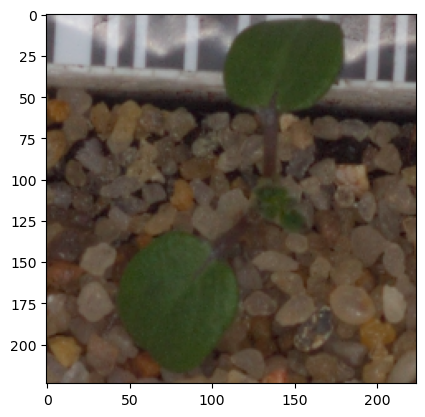

In [33]:
plt.imshow(test_lst[3].transpose(1,2,0))

In [34]:
## Custom Dataset
from glob import glob
class Seeds_test(Dataset):
    def __init__(self,data,transform=None):
        self.data = data 
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        image= self.data[idx]
        image = torch.tensor(image).float()
        if self.transform is not None:
            image = self.transform(image)
        return image

In [35]:
transformss2 = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor(),transforms.Normalize((0.7941, 0.7151, 0.6756), (0.1343, 0.1106, 0.1050))])

In [36]:
test_seeds_data = Seeds_test(test_lst,transform=transformss2)
test_seeds_data

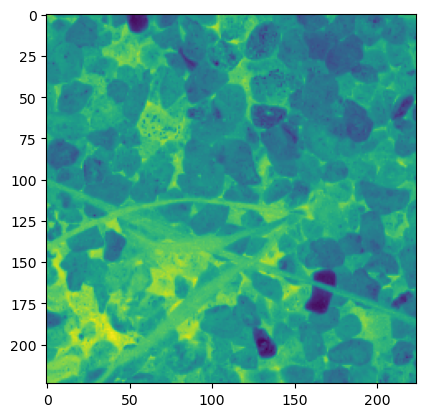

In [37]:
plt.imshow(next(iter(test_seeds_data))[0])

In [38]:
testing_data = DataLoader(test_seeds_data, batch_size=32, shuffle=True,**cuda_kwargs)

In [39]:
len(testing_data)

25

In [40]:
next(iter(testing_data))[0].shape

torch.Size([3, 224, 224])

In [41]:
next(iter(testing_data))[3].numpy().shape

(3, 224, 224)

In [42]:
# Transform
img2 = next(iter(testing_data))[11]
# Set model to eval
model.eval()
inp_img1 = input.squeeze().unsqueeze(0).to("cuda")
print(inp_img1.shape)
# Get prediction
# output = model(input.to("cuda").float())
prediction = F.softmax(model(inp_img1), dim = 0)
prediction = prediction.argmax()
classes[prediction]

torch.Size([1, 3, 230, 230])


'scentless_mayweed'

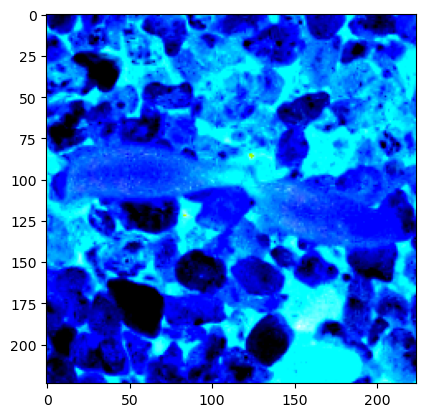

In [43]:
plt.imshow(next(iter(testing_data))[11].numpy().transpose(2,1,0))

**H. Analyzing the results:**

1. As we observe, there is a lot of fluctuations happening in the validation-accuracy. According to GPT, the issues would be 

> **Overfitting**: If your model is overfitting to the training data, the validation loss may fluctuate as the model tries to generalize to unseen data. This can happen when your model is too complex or has too many parameters compared to the amount of training data available.

>**Learning rate**: If the learning rate is too high, the model's optimization may overshoot the minimum, causing the loss to fluctuate. On the other hand, if the learning rate is too low, the optimization process may take a long time to converge, which can also cause fluctuations in the validation loss.

> **Dataset variability**: The variability in the validation dataset can also cause fluctuations in the validation loss. This can happen if the validation dataset contains samples that are significantly different from the training dataset or if it contains a small number of samples.

> **Random initialization**: Neural networks are initialized with random weights, so the initial validation loss can be different for each run. This can cause fluctuations in the validation loss as the model is trained.

> **Optimization algorithm**: The optimization algorithm used to train the model can also impact the validation loss. Some optimization algorithms may converge faster than others, while others may struggle to escape from local minima, leading to fluctuations in the validation loss.

To address these issues, it's important to use techniques such as regularization, early stopping, and hyperparameter tuning to improve the generalization of your model and reduce the fluctuations in the validation loss.

---------------------------------------------------

From this, we can observe and relate to three points here. 

1. **Overfitting**: because we have only 4750 images where our network parameter stands exponential count to it. We may have generate images via augmentation and or reduce network parameters or both. 

2. **Dataset variability**: we have very few number of images per each class and also we have done random splitting of data to train & validation. As we did splitted randomly, for example, if class A has 12 images and class B has 3 images, as we split it randomly, all the images of A would have been in train & all B images would have been in validation set. There is a need to take data and generate new set of images via augmentation  take some percent of images per each class, that would make them balanced. Didn't maintain more data & dealt with large capacity.

3. Reaching minima, would have made any difference in each epoch.

**Reference :** 

https://stats.stackexchange.com/questions/255105/why-is-the-validation-accuracy-fluctuating



**Observations:** 

  1. By viewing some of images of 'common_chickweed' in training images, we can find whether the 'common_chickweed' plant is equal to test_image we passed it or not.
    
  2. As for me, its not at all equal,so they are completely mis-classified. We have to improve the model either
    by tweaking architecture or using data augmentation or improving data or adding regularization techniques.